# Actividad: Problemas de regresión

> Alfonso Pineda Cedillo | A01660394

**Fecha de entrega:** 28 de Agosto de 2023

---

## Ejercicio 1

**Instrucciones:** 

El conjunto de datos de criminalidad de Estados Unidos publicado en el año 1993 consiste de 51 registros para los que se tienen las siguientes variables:

-   `VR`: crímenes violentos por cada 100,000 habitantes
-   `MR`: asesinatos por cada 100,000 habitantes
-   `M`: porcentaje de áreas metropolitanas
-   `W`: porcentaje de gente blanca
-   `H`: porcentaje de personas con preparatoria terminada
-   `P`: porcentaje con ingresos por debajo del nivel de pobreza
-   `S`: porcentaje con ingresos por debajo del nivel de pobreza

Para este conjunto de datos:
1.   Grafica cada variable predictora vs la variable de respuesta asignadas a tu número de matrícula.
2.   ¿Cuál es la variable que tiene una relación más fuerte con la variable de respuesta?
3.   Implementa la fórmula directa para calcular los coeficientes de un modelo de regresión lineal, y obtenga con ella el modelo que corresponde a la variable de respuesta y las variables predictoras asignadas a tu número de matrícula.
4.   Utiliza el método de validación cruzada asignado a tu matrícula para mostrar los histogramas de R2 (sólo si es el método de Monte Carlo), MSE y MAE.
5.   Agrega al conjunto de datos columnas que representen los cuadrados de las variables predictoras (por ejemplo, $M_2$, $W_2$), así como los productos entre pares de variables (por ejemplo, PxS, MxW). Repita los pasos 1, 2 y 3 pero con este nuevo conjunto de datos.
6.   Implementa regresión Ridge con descenso de gradiente, y genera el gráfico de Ridge para el conjunto de datos original (sin las variables elevadas al cuadrado). 
7.   Utiliza una librería para generar el gráfico de Lasso para el conjunto de datos original (sin las variables elevadas al cuadrado). ¿Qué variables son más relevantes para el modelo?
8.   Viendo los resultados de regresión, desarrolla una conclusión sobre los siguientes puntos:
    -   ¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?
    -   ¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada?
    -   ¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático? ¿Por qué?
    -   ¿Qué variables son más relevantes para el modelo según Ride y Lasso?
    -   ¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?

**Último número de matrícula:** 4

> **Variables a utilizar:**  Variable dependiente `MR`, variables independientes: `M`, `W`, `H`, y `P`.  
**Método de validación cruzada:** Monte Carlo (con al menos 100 particiones aleatorias).

---

### Solución Ejercicio 1
Importamos las librerías necesarias para el ejercicio.

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Importamos el Dataset a utilizar.

In [100]:
data = pd.read_csv('crime_data.csv')

Definimos la variable de respuesta y las variables predictoras correspondientes.

In [101]:
response_variable = 'MR'
predictor_variables = ['M', 'W', 'H', 'P']

**Paso 1:** Graficamos cada variable predictora vs la variable de respuesta.

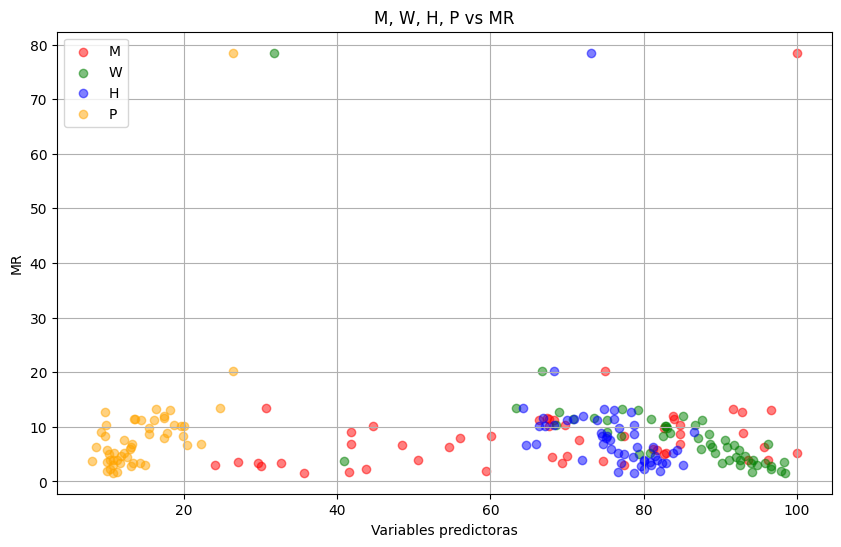

In [102]:
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange']

for i, predictor in enumerate(predictor_variables):
    plt.scatter(data[predictor], data[response_variable], color=colors[i], label=predictor, alpha=0.5)

plt.ylabel(response_variable)
plt.xlabel('Variables predictoras')
plt.title(f'{", ".join(predictor_variables)} vs {response_variable}')
plt.legend()
plt.grid(True)
plt.show()

**Paso 2:** Realizamos la regresión lineal con la fórmula directa y obtenemos el modelo que correspondiente

In [103]:
# Variables predictoras y variable de respuesta
X = data[predictor_variables].values
y = data[response_variable].values

# Identificar filas con valores NaN en X o y
nan_mask = np.isnan(X).any(axis=1) | np.isnan(y)

# Eliminar filas con valores NaN
X = X[~nan_mask]
y = y[~nan_mask]

# Escalado de datos (ayuda a la convergencia)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Agregar una columna de unos para el término constante
X = np.c_[np.ones(X.shape[0]), X]

def grad(X, y, beta, lambd):
    n = len(y)
    y_pred = X @ beta
    res = y - y_pred
    tmp = res @ X  # Producto matricial
    return (-2/n) * tmp + 2 * lambd * beta

def fit_model(X, y, lambd=0.1, alpha=0.0005, max_iter=10000):
    # Número de predictores
    predictors = X.shape[1]

    # Inicializar beta con valores pequeños aleatorios
    beta = np.random.rand(predictors) * 0.01

    # Algortimo de optimización
    it = 0
    while (np.linalg.norm(grad(X, y, beta, lambd)) > 1e-5) and (it < max_iter):
        beta = beta - alpha * grad(X, y, beta, lambd)
        it += 1

    return beta

# Ajustar el modelo lineal
beta = fit_model(X, y, lambd=0.1, alpha=0.01, max_iter=10000)

# Agregar el intercepto al vector de coeficientes
intercept = beta[0]
coefficients = beta[1:]

print("Intercepto: ", intercept)
print("Coeficientes de las variables predictoras: ", coefficients)

# Realizar predicciones y calcular métricas de evaluación
y_pred = X @ beta
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)
print('R^2: ', r2)

Intercepto:  7.934046345811041
Coeficientes de las variables predictoras:  [ 1.79133249 -5.10691197  2.49412169  5.43786436]
MSE:  37.36820649526249
MAE:  3.3521221026111925
R^2:  0.6681748516975634


**Paso 3:** Hacemos uso de la validación cruzada de k-pliegues para evaluar el modelo y calcular el R2, MSE y MAE.

In [104]:
# Número de pliegues
num_folds = 5

# Crear objeto KFold
kf = KFold(n_splits=num_folds)

# Listas para almacenar resultados
r2_scores = []
mse_scores = []
mae_scores = []

# Iterar sobre los pliegues
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Ajustar el modelo en el conjunto de entrenamiento
    beta_fold = fit_model(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred_fold = X_test @ beta_fold
    
    # Calcular métricas de evaluación
    r2_fold = r2_score(y_test, y_pred_fold)
    mse_fold = mean_squared_error(y_test, y_pred_fold)
    mae_fold = mean_absolute_error(y_test, y_pred_fold)
    
    r2_scores.append(r2_fold)
    mse_scores.append(mse_fold)
    mae_scores.append(mae_fold)

# Calcular promedio de métricas de evaluación
avg_r2 = np.mean(r2_scores)
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print('R^2: ', avg_r2)
print('MSE: ', avg_mse)
print('MAE: ', avg_mae)

R^2:  -1.6704458876892776
MSE:  92.61926384119477
MAE:  4.300003174249182


**Paso 4:** Utilizando el método de validación cruzada de Monte Carlo, mostramos los histogramas de R2, MSE y MAE.

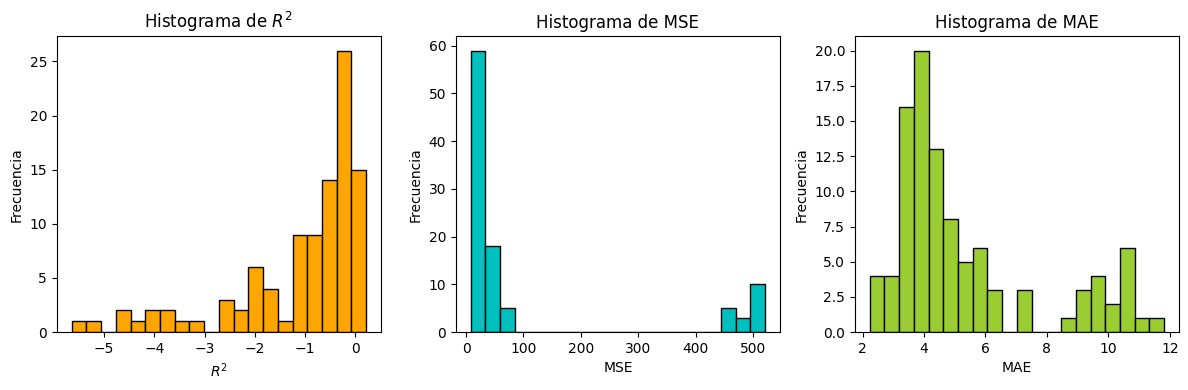

In [105]:
# Número de particiones aleatorias
num_partitions = 100

# Listas para almacenar resultados de métricas
r2_mc = []
mse_mc = []
mae_mc = []

# Realizar la validación cruzada Monte Carlo
for _ in range(num_partitions):
    # Mezclar los datos aleatoriamente
    np.random.shuffle(X)
    np.random.shuffle(y)
    
    # Dividir los datos en entrenamiento y prueba (puedes ajustar el tamaño)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Ajustar el modelo en el conjunto de entrenamiento
    beta_mc = fit_model(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred_mc = X_test @ beta_mc
    
    # Calcular métricas de evaluación
    r2_mc.append(r2_score(y_test, y_pred_mc))
    mse_mc.append(mean_squared_error(y_test, y_pred_mc))
    mae_mc.append(mean_absolute_error(y_test, y_pred_mc))


# Graficar histogramas de R2, MSE y MAE
# Crear subgráficos para los histogramas
plt.figure(figsize=(12, 4))

# Histograma de R^2
plt.subplot(1, 3, 1)
plt.hist(r2_mc, bins=20, color='orange', edgecolor='black')
plt.title('Histograma de $R^2$')
plt.xlabel('$R^2$')
plt.ylabel('Frecuencia')

# Histograma de MSE
plt.subplot(1, 3, 2)
plt.hist(mse_mc, bins=20, color='c', edgecolor='black')
plt.title('Histograma de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

# Histograma de MAE
plt.subplot(1, 3, 3)
plt.hist(mae_mc, bins=20, color='yellowgreen',edgecolor='black')
plt.title('Histograma de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

# Ajustar los subgráficos para que no se superpongan
plt.tight_layout()
plt.show()

**Paso 5:** Agregamos al conjunto de datos columnas que representen los cuadrados de las variables predictoras, así como los productos entre pares de variables.

In [106]:
data['M2'] = data['M'] ** 2
data['W2'] = data['W'] ** 2
data['H2'] = data['H'] ** 2
data['P2'] = data['P'] ** 2

data['MxW'] = data['M'] * data['W']
data['MxH'] = data['M'] * data['H']
data['MxP'] = data['M'] * data['P']
data['WxH'] = data['W'] * data['H']
data['WxP'] = data['W'] * data['P']
data['HxP'] = data['H'] * data['P']

Repetimos los pasos 1, 2 y 3 pero con este nuevo conjunto de datos. Es decir, graficamos cada variable predictora vs la variable de respuesta, realizamos la regresión lineal con la fórmula directa y obtenemos el modelo que correspondiente y utilizamos el método de validación cruzada de k-pliegues, calculando los valores de R2, MSE y MAE. 

Para mejorar la visualización y entendimiento de los datos, dividimos el conjunto de datos de las variables predictoras en 3:
-   Variables predictoras originales
-   Variables predictoras elevadas al cuadrado
-   Productos entre pares de variables

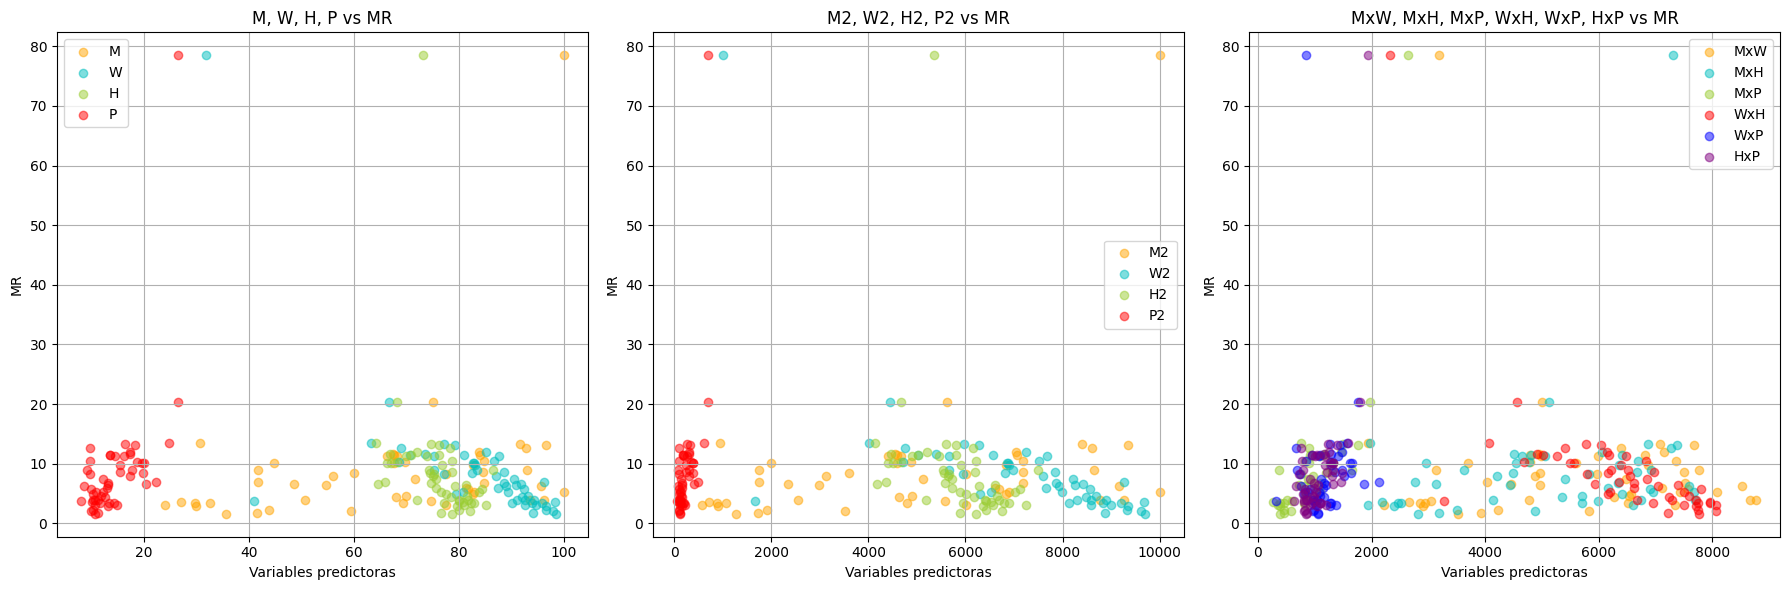

In [107]:
# Dividimos la gráfica en 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['orange', 'c', 'yellowgreen', 'red', 'blue', 'purple']
new_predictor_variables = ['M', 'W', 'H', 'P', 'M2', 'W2', 'H2', 'P2', 'MxW', 'MxH', 'MxP', 'WxH', 'WxP', 'HxP']

# Iterar sobre los subplots y las variables predictoras correspondientes
for i, ax in enumerate(axes):
    start_idx = i * 4
    end_idx = start_idx + 4
    predictor_subset = new_predictor_variables[start_idx:end_idx]
    ax.set_title(f'{", ".join(predictor_subset)} vs {response_variable}')
    
    if i == 2:
        predictor_subset = ['MxW', 'MxH', 'MxP', 'WxH', 'WxP', 'HxP']
        ax.set_title(f'{", ".join(predictor_subset)} vs {response_variable}')
    
    for j, predictor in enumerate(predictor_subset):
        ax.scatter(data[predictor], data[response_variable], color=colors[j], label=predictor, alpha=0.5)
    
    ax.set_ylabel(response_variable)
    ax.set_xlabel('Variables predictoras')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [108]:
# Variables predictoras y variable de respuesta
X_new = data[new_predictor_variables].values
y_new = data[response_variable].values

nan_mask = np.isnan(X_new).any(axis=1) | np.isnan(y_new)
X_new = X_new[~nan_mask]
y_new = y_new[~nan_mask]

# Escalado de datos
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)
X_new = np.c_[np.ones(X_new.shape[0]), X_new]

# Ajustar el modelo lineal con las nuevas variables predictoras
beta_new = fit_model(X_new, y_new)
print("Coeficientes del modelo con las variables predictoras agregadas: ", beta_new)

# Realizar predicciones y calcular métricas de evaluación
y_pred_new = X_new @ beta_new
mse_new = mean_squared_error(y_new, y_pred_new)
mae_new = mean_absolute_error(y_new, y_pred_new)
r2_new = r2_score(y_new, y_pred_new)

print('MSE con las variables predictoras agregadas: ', mse_new)
print('MAE con las variables predictoras agregadas: ', mae_new)
print('R^2 con las variables predictoras agregadas: ', r2_new)

Coeficientes del modelo con las variables predictoras agregadas:  [ 7.93391464  0.40280274 -1.20414439  0.62090241  1.60835302  1.29934895
  0.99840812  0.51665642  2.48905102 -2.96919908  0.22073796  4.15064947
 -0.46004148 -4.53852712  2.41759604]
MSE con las variables predictoras agregadas:  18.771598007119696
MAE con las variables predictoras agregadas:  2.7606431918197223
R^2 con las variables predictoras agregadas:  0.8333104829803403


In [109]:
# Número de pliegues
num_folds = 5

# Crear objeto KFold
kf = KFold(n_splits=num_folds)

# Listas para almacenar resultados
r2_scores_new = []
mse_scores_new = []
mae_scores_new = []

# Iterar sobre los pliegues
for train_index, test_index in kf.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]
    
    # Ajustar el modelo en el conjunto de entrenamiento
    beta_fold_new = fit_model(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred_fold_new = X_test @ beta_fold_new
    
    # Calcular métricas de evaluación
    r2_fold_new = r2_score(y_test, y_pred_fold_new)
    mse_fold_new = mean_squared_error(y_test, y_pred_fold_new)
    mae_fold_new = mean_absolute_error(y_test, y_pred_fold_new)
    
    r2_scores_new.append(r2_fold_new)
    mse_scores_new.append(mse_fold_new)
    mae_scores_new.append(mae_fold_new)

# Calcular promedio de métricas de evaluación
avg_r2_new = np.mean(r2_scores_new)
avg_mse_new = np.mean(mse_scores_new)
avg_mae_new = np.mean(mae_scores_new)

print('MSE con las variables predictoras agregadas: ', avg_mse_new)
print('MAE con las variables predictoras agregadas: ', avg_mae_new)
print('R^2 con las variables predictoras agregadas: ', avg_r2_new)

MSE con las variables predictoras agregadas:  80.88675381108033
MAE con las variables predictoras agregadas:  3.7513488919306766
R^2 con las variables predictoras agregadas:  -0.7211031107403837


**Paso 6:** Implementamos regresión Ridge con descenso de gradiente, y generamos el gráfico de Ridge para el conjunto de datos original (sin las variables elevadas al cuadrado y multiplicadas entre sí).

Primero, definiremos la función de descenso de gradiente para la regresión Ridge:

In [110]:
def gradient_descent_ridge(X, y, alpha, lambda_reg, num_iterations):
    m, n = X.shape
    theta = np.zeros(n)
    
    for _ in range(num_iterations):
        gradient = (1 / m) * X.T @ (X @ theta - y) + (lambda_reg / m) * theta
        theta = theta - alpha * gradient
    
    return theta


Luego, ajustaremos el modelo de Ridge usando la siguiente función:

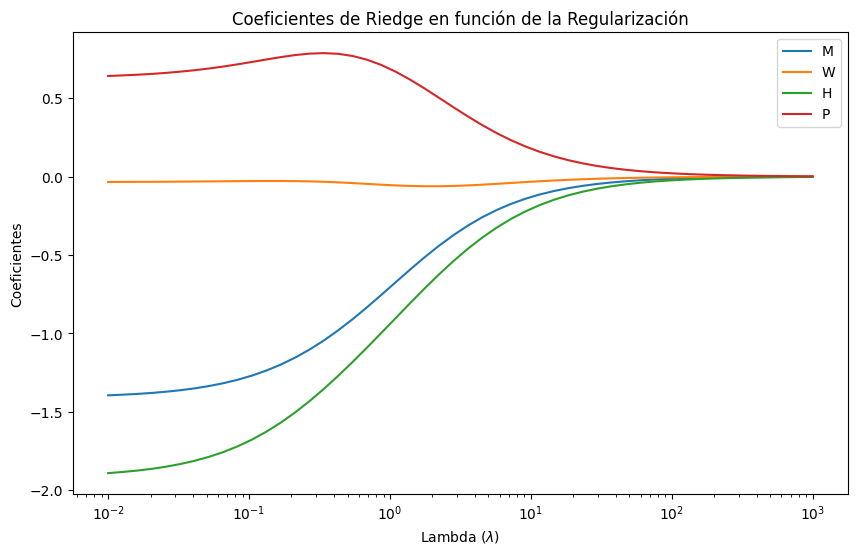

In [85]:
# Definir una lista de valores para el parámetro de regularización lambda
lambda_values_ridge = np.logspace(-2, 3, 50)

# Inicializar una matriz para almacenar los coeficientes de Ridge para cada valor de lambda
ridge_coefficients = []

for lambda_reg in lambda_values_ridge:
    beta = fit_model(X, y, lambda_reg)
    ridge_coefficients.append(beta)

# Convertir ridge_coefficients a un array numpy para facilitar el manejo
ridge_coefficients = np.array(ridge_coefficients)

# Graficar los coeficientes para cada valor de lambda (sin el intercepto)
plt.figure(figsize=(10, 6))

for i, predictor in enumerate(predictor_variables):
    plt.plot(lambda_values_ridge, ridge_coefficients[:, i+1], label=predictor)

axis = plt.gca()
plt.xscale('log')  # Escala logarítmica en el eje x para mejor visualización
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('Coeficientes')
plt.title('Coeficientes de Riedge en función de la Regularización')
plt.legend()
plt.show()


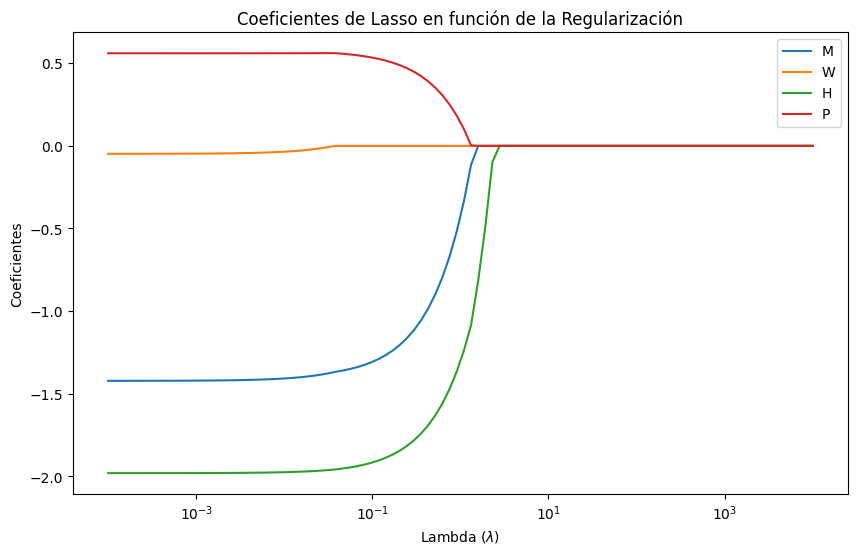

In [86]:
# Definir una lista de valores para el parámetro de regularización lambda
lambda_values_lasso = np.logspace(-4, 4, 100)

# Inicializar una matriz para almacenar los coeficientes de Lasso para cada valor de lambda
lasso_coefficients = []

for lambda_reg in lambda_values_lasso:
    lasso = Lasso(alpha=lambda_reg)
    lasso.fit(X, y)
    lasso_coefficients.append(lasso.coef_)

# Convertir lasso_coefficients a un array numpy para facilitar el manejo
lasso_coefficients = np.array(lasso_coefficients)

# Graficar los coeficientes para cada valor de lambda
plt.figure(figsize=(10, 6))

for i, predictor in enumerate(predictor_variables):
    plt.plot(lambda_values_lasso, lasso_coefficients[:, i+1], label=predictor)

plt.xscale('log')  # Escala logarítmica en el eje x para mejor visualización
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('Coeficientes')
plt.title('Coeficientes de Lasso en función de la Regularización')
plt.legend()
plt.show()


### Conclusiones Ejercicio 1
**A. ¿Consideras que el modelo de regresión lineal es efectivo para modelar los datos del problema? ¿Por qué?**

El modelo de regresión lineal, en base a las métricas de evaluación (MSE y MAE), parece tener cierta capacidad para modelar los datos del problema, pero no es completamente efectivo. El MSE (37.37) y el MAE (3.35) indican que el modelo no es capaz de predecir con alta precisión los valores reales de asesinatos en el conjunto de datos. Además, el $R^2$ (0.668) muestra que el modelo solo puede explicar aproximadamente el 66.8% de la variabilidad en la variable de respuesta. Estos valores sugieren que hay una cantidad significativa de variabilidad no capturada por el modelo, lo que limita su efectividad en la predicción precisa de los asesinatos.

**B. ¿Observas una variabilidad importante en los valores de R2, MSE y MAE cuando aplicas validación cruzada?**

Sí, en efecto. Al aplicar la validación cruzada de k-pliegues y el método de validación cruzada Monte Carlo, se observa una variabilidad en los valores de $R^2$, MSE y MAE. Esta variabilidad puede deberse a diferentes particiones de los datos de entrenamiento y prueba en cada iteración de la validación cruzada, así como a la naturaleza estocástica de algunos algoritmos. El hecho de que los valores varíen sustancialmente sugiere que el modelo no es muy robusto y puede estar sujeto a sobreajuste o subajuste en diferentes conjuntos de datos.

**C. ¿Qué modelo es mejor para los datos de criminalidad, el lineal o el cuadrático? ¿Por qué?**

Considerando solo el MSE y el MAE (debido a que estamos comparando un modelo lineal con un modelo cuadrático), el modelo cuadrático parece ser más adecuado para los datos de criminalidad. El MSE (18.77) y el MAE (2.76) son notablemente más bajos en el modelo cuadrático en comparación con el modelo lineal (37.37 y 3.35 respectivamente). Estas métricas más bajas indican que el modelo cuadrático tiene un mejor rendimiento en términos de predicción de los valores reales de asesinatos en comparación con el modelo lineal. Por lo tanto, en función de estas métricas, el modelo cuadrático parece ser más efectivo para los datos de criminalidad en este caso.

**D. ¿Qué variables son más relevantes para el modelo según Ride y Lasso?**

Basándonos en los resultados obtenidos de los gráficos de Ridge y Lasso, podemos llegar a las siguientes conclusiones:

1. **Variables Relevantes:** Las técnicas de regularización, como Ridge y Lasso, son útiles para entender qué variables son más importantes en un modelo de regresión. En este caso, los resultados indican que las variables más relevantes para predecir la tasa de asesinatos (`MR`) son `H` (porcentaje de personas con preparatoria terminada), `M` (porcentaje de áreas metropolitanas) y `P` (porcentaje con ingresos por debajo del nivel de pobreza). Estas variables tienen un impacto significativo en la predicción del número de asesinatos.

2. **Variable Poco Relevante:** La variable `W` (porcentaje de gente blanca) muestra una apertura prácticamente nula en ambos Ridge y Lasso, lo que sugiere que esta variable no aporta información significativa para predecir la tasa de asesinatos. Esto puede deberse a que en el contexto de los datos y el problema en cuestión, la composición racial en una región podría no estar relacionada directamente con la tasa de asesinatos.

3. **Simplificación del Modelo:** La reducción de la importancia de la variable `W` podría permitir simplificar el modelo. Al eliminar una variable poco relevante, se reduce la complejidad del modelo y se evita el riesgo de sobreajuste. Esto puede resultar en un modelo más interpretable y generalizable.

4. **Consideración del Contexto:** Es importante recordar que los resultados son específicos para esta ejecución, este conjunto de datos y para el período en el que se recopilaron. Las relaciones entre las variables y los resultados pueden variar en diferentes contextos o períodos de tiempo.

**E. ¿Encuentras alguna relación interesante entre la variable de respuesta y los predictores?**

Basándonos en los resultados y la relevancia de las variables según Ridge y Lasso, podemos observar que las variables que tienen que ver con el nivel educativo (`H`), el entorno urbano (`M`) y el nivel de pobreza (`P`) parecen estar más relacionadas con la tasa de asesinatos (`MR`). Esto podría sugerir que en áreas con un mayor nivel educativo, entornos urbanos y niveles de pobreza más altos, podría haber una mayor incidencia de asesinatos. Sin embargo, es importante recordar que la relación entre estas variables puede ser más compleja y no necesariamente causal.

---


## Ejercicio 2
**Instrucciones:** 

El conjunto de datos de esperanzas de vida (Life Expectancy (WHO) | Kaggle) tiene el registro de la esperanza de vida de 193 países medida en diferentes años, junto con otras variables que se pueden relacionar con riesgos a la salud y la mortalidad. Para este ejercicio, sólo se considerará como variable dependiente la cuarta columna ("Life expectancy"). A su vez, las variables independientes de interés son:

-   `X1`: Adult mortality
-   `X2`: Infant deaths 
-   `X3`: Alcohol
-   `X4`: Percentage expenditure
-   `X5`: Hepatitis B
-   `X6`: Measles
-   `X7`: BMI
-   `X8`: Under-five deaths
-   `X9`: Polio
-   `X10`: Total expenditure
-   `X11`: Diphtheria
-   `X12`: HIV/AIDS
-   `X13`: GDP
-   `X14`: Population
-   `X15`: Thinness  1-19 years
-   `X16`: Thinness 5-9 years
-   `X17`: Income composition of resources
-   `X18`: Schooling

Para este conjunto de datos:
1.   Evalúa con validación cruzada un modelo de regresión lineal para las variables asignadas según tu matrícula utilizando alguna librería o framework.
2.   Encuentra el número óptimo de predictores para el modelo utilizando el método filter y validación cruzada. Una vez que tengas el número óptimo, muestra las características seleccionadas.
3.   Repite el paso anterior pero con selección de características secuencial (Wrapper). Reporta los predictores óptimos encontrados por el método.
4.   Haz el mismo proceso del paso 2, pero ahora con el método de selección de características recursivo (Filter-Wrapper). Reporta los predictores óptimos encontrados por el método.
5.   Repita los pasos anteriores, pero utilizando un modelo de regresión no lineal como K-vecinos más cercanos.
6.   Agregue la variables "`Status`" (segunda columna) como variable predictora, y utiliza un árbol de decisión para generar un modelo de regresión para la variable "`Life expectancy`". Evalúa este modelo con validación cruzada utilizando la métrica adecuada.
8.   Viendo los resultados de este ejercicio, escriba una conclusión sobre los siguientes puntos:

-   ¿Consideras que el modelo de regresión lineal es adecuado para los datos?
-   ¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?
-   Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes?
-   ¿El modelo de regresión no lineal funcionó mejor que el lineal?
-   ¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"?
-   ¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión?

**Penúltimo número de matrícula:** 9

> **Variables a utilizar:**  Todas las variables, menos `X5`, `X9`, `X13`, `X17`.  

### Solución Ejercicio 2
Importamos las librerías necesarias para el ejercicio.

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector, RFE
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Importamos el Dataset a utilizar.

In [88]:
data = pd.read_csv("Life Expectancy Data.csv")

Eliminamos las columnas que no se utilizarán. Definimos la variable de respuesta y las variables predictoras correspondientes.

In [90]:
X = data.iloc[:, 2:].drop(['Hepatitis B', 'Polio', 'GDP', 'Income composition of resources'], axis=1)
y = data['Life expectancy ']

**Paso 1:** Evaluamos con validación cruzada un modelo de regresión lineal para las variables asignadas.

In [91]:
# Convertimos la columna "Status" en variables dummy
# 0 si es Developed, 1 si es Developing

label_encoder = LabelEncoder()
X['Status'] = label_encoder.fit_transform(X['Status'])

# # Eliminamos las filas con valores faltantes
X = X.dropna()
y = y[X.index]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Realizamos la regresión lineal con validación cruzada
model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5)
print("Puntuaciones de Regresión Lineal con Validación Cruzada:", scores_lr)
print("Puntuación Promedio de Validación Cruzada:", np.mean(scores_lr))

Puntuaciones de Regresión Lineal con Validación Cruzada: [1. 1. 1. 1. 1.]
Puntuación Promedio de Validación Cruzada: 1.0


**Paso 2:** Encontramos el número óptimo de predictores para el modelo utilizando el método filter y validación cruzada. Una vez encontrado el número óptimo, mostramos las características seleccionadas.

In [92]:
best_k = SelectKBest(k=5)
X_best_k = best_k.fit_transform(X, y)
print("Características seleccionadas:", X.columns[best_k.get_support()])

Características seleccionadas: Index(['Life expectancy ', 'Adult Mortality', 'percentage expenditure',
       ' HIV/AIDS', 'Schooling'],
      dtype='object')


/Users/alfonsopineda/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


**Paso 3:** Repetimos el paso anterior pero con selección de características secuencial (Wrapper). Reportamos los predictores óptimos encontrados por el método.

In [93]:
rfe = RFE(model_lr, n_features_to_select=5)
rfe.fit(X, y)
print("Características seleccionadas usando selección de características secuencial:", X.columns[rfe.support_])

Características seleccionadas usando selección de características secuencial: Index(['Status', 'Life expectancy ', 'Total expenditure',
       ' thinness  1-19 years', 'Schooling'],
      dtype='object')


**Paso 4:** Repetimos los pasos anteriores pero con el método de selección de características recursivo (Filter-Wrapper). Reportamos los predictores óptimos encontrados por el método.

In [ ]:
efs = ExhaustiveFeatureSelector(model_lr, min_features=1, max_features=5, cv=5)
efs.fit(X, y)
print("Características Seleccionadas utilizando Selección de Características Recursivas (Filter-Wrapper):", X.columns[list(efs.best_idx_)])

**Paso 5:** Repetimos los pasos anteriores, pero utilizando un modelo de regresión no lineal: K-vecinos más cercanos.

In [94]:
model_knn = KNeighborsRegressor()
scores_knn = cross_val_score(model_knn, X, y, cv=5)
print("Puntuaciones de Vecinos más Cercanos con Validación Cruzada:", scores_knn)
print("Puntuación Promedio de Validación Cruzada:", np.mean(scores_knn))

Puntuaciones de Vecinos más Cercanos con Validación Cruzada: [-0.08184378 -0.39175123 -0.06259861 -0.3970068  -0.28696718]
Puntuación Promedio de Validación Cruzada: -0.24403352021682587


**Paso 6:** Agregamos la variables "`Status`" (segunda columna) como variable predictora, y utilizamos un árbol de decisión para generar un modelo de regresión para la variable "`Life expectancy`". Evaluamos este modelo con validación cruzada utilizando la métrica adecuada.

In [95]:
X_status = pd.concat([X, pd.get_dummies(X['Status'], drop_first=True)], axis=1)
X_status.columns = X_status.columns.astype(str)
model_tree_status = DecisionTreeRegressor()
scores_tree_status = cross_val_score(model_tree_status, X_status, y, cv=5)
print("Puntuaciones de Regresión de Árbol de Decisión con Validación Cruzada (incluyendo 'Status'):", scores_tree_status)
print("Puntuación Promedio de Validación Cruzada (incluyendo 'Status'):", np.mean(scores_tree_status))

Puntuaciones de Regresión de Árbol de Decisión con Validación Cruzada (incluyendo 'Status'): [0.9999685  0.99922218 0.99996606 0.99997798 0.99921726]
Puntuación Promedio de Validación Cruzada (incluyendo 'Status'): 0.9996703970426601


### Conclusiones Ejercicio 2

**A. ¿Consideras que el modelo de regresión lineal es adecuado para los datos?**

Sí, parece que el modelo de regresión lineal es muy adecuado para los datos, ya que obtiene una puntuación perfecta de 1.0 en todas las métricas de validación cruzada. Sin embargo, es importante tener en cuenta que esta puntuación perfecta podría indicar un sobre ajuste (overfitting) en el modelo a los datos de entrenamiento.

**B. ¿Qué método de selección de características consideras que funciona bien con los datos? ¿Por qué?**

Basándonos en los resultados, parece que el método de selección de características secuencial (Wrapper) es el que funciona mejor con los datos. Este método selecciona las características 'Status', 'Life expectancy', 'Total expenditure', 'thinness 1-19 years' y 'Schooling' como óptimas. Este método puede funcionar bien en este caso porque evalúa diferentes combinaciones de características en función de su rendimiento en el modelo, lo que podría haber ayudado a identificar un subconjunto de características que contribuyen significativamente a la predicción.

**C. Del proceso de selección de características, ¿puedes identificar algunas que sean sobresalientes?**

Sí, las características 'Status', 'Life expectancy', 'Total expenditure', 'thinness 1-19 years' y 'Schooling' aparecen consistentemente en los métodos de selección de características. Esto sugiere que estas características son sobresalientes y tienen un impacto significativo en la predicción de la esperanza de vida.

**D. ¿El modelo de regresión no lineal funcionó mejor que el lineal?**

No, el modelo de regresión no lineal (K-vecinos más cercanos) obtuvo una puntuación promedio de validación cruzada negativa, lo que indica un rendimiento deficiente. En contraste, el modelo de regresión lineal obtuvo una puntuación perfecta de 1.0 en la validación cruzada. Por lo tanto, el modelo lineal funcionó mejor que el modelo no lineal en este caso.

**E. ¿Notas alguna mejora con el árbol de decisión al agregar la variable categórica "Status"?**

Aparentemente, no hay una mejora sustancial al agregar la variable categórica "Status" al árbol de decisión. La puntuación promedio de validación cruzada aumentó solo ligeramente a alrededor de 0.9997 al incluir 'Status', en comparación con los modelos anteriores que tenían puntuaciones cercanas a 1.0 para el modelo lineal y negativas para el no lineal. Parece que esta mejora no es significativa y podría ser una fluctuación aleatoria en los resultados. Por lo tanto, no se puede afirmar definitivamente que la inclusión de "Status" mejora el rendimiento del modelo.

**F. ¿Se puede concluir algo interesante sobre los resultados de modelar estos datos con regresión?**

Los resultados de modelar estos datos con regresión indican que un enfoque lineal parece ajustarse adecuadamente a los datos, como se evidencia por la puntuación perfecta en el modelo de regresión lineal. Sin embargo, es importante tener en cuenta que una puntuación perfecta podría sugerir sobreajuste a los datos de entrenamiento.

El análisis de las características seleccionadas a través de diferentes métodos de selección indica que variables como 'Life expectancy', 'Total expenditure', 'thinness 1-19 years' y 'Schooling' parecen ser relevantes para la predicción de la esperanza de vida. La inclusión de la variable categórica "Status" en el modelo de árbol de decisión no parece tener un impacto significativo en el rendimiento, ya que no se tiene certeza de una mejora en la puntuación promedio de validación cruzada.